In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import os, copy
import time
import imp

import OMRobjects as OMR
import util_functions as fs

imp.reload(OMR)
imp.reload(fs)

%matplotlib inline

In [2]:
sheet_path = './data/You_to_me_me_to_you'
sheets = [OMR.Sheet(os.path.join(sheet_path, page_path), order=i) for i, page_path in enumerate(sorted(os.listdir(sheet_path)))]

* Sheet Object Created :: Sheet #0 :: ./data/You_to_me_me_to_you/p1.png :: (1809, 1280)
* Sheet Object Created :: Sheet #1 :: ./data/You_to_me_me_to_you/p2.png :: (1809, 1280)
* Sheet Object Created :: Sheet #2 :: ./data/You_to_me_me_to_you/p3.png :: (1809, 1280)
* Sheet Object Created :: Sheet #3 :: ./data/You_to_me_me_to_you/p4.png :: (1809, 1280)


In [3]:
sheet_sample = 0

sheets[sheet_sample].preprocess_image(threshold=200)
sheets[sheet_sample].create_system(sheets[sheet_sample])

systems = sheets[sheet_sample].systems

>>> Preprocessing Page #00 :: ./data/You_to_me_me_to_you/p1.png
* Deskewing :: PASS
* Resizing :: PASS
* Denoising :: PASS
* Inverse binary thresholding :: threshold=200
>>> Extracting systems : 5 systems
* System Object Created :: System #0 of [...you/p1.png] :: (x, y, w, h) = (83, 188, 1136, 230)
* System Object Created :: System #1 of [...you/p1.png] :: (x, y, w, h) = (79, 479, 1140, 220)
* System Object Created :: System #2 of [...you/p1.png] :: (x, y, w, h) = (80, 773, 1139, 238)
* System Object Created :: System #3 of [...you/p1.png] :: (x, y, w, h) = (83, 1070, 1136, 259)
* System Object Created :: System #4 of [...you/p1.png] :: (x, y, w, h) = (83, 1382, 1137, 247)


In [4]:
system_sample = 0

systems[system_sample].get_pixel_histogram(depend_on='row')
systems[system_sample].get_pixel_histogram(depend_on='col', grid=[0.3, 0.5, 0.7, 0.9, 0.95])

hline_pos, hthickness = systems[system_sample].get_line_info(hist_by='row')
vline_pos, vthickness = systems[system_sample].get_line_info(hist_by='col')
vline_pos, vthickness = systems[system_sample].check_bar()

systems[system_sample].reset_line_removed_image()
systems[system_sample].remove_lines(hline_pos, hthickness, direction='hor')
systems[system_sample].remove_lines(vline_pos, vthickness, direction='ver')
systems[system_sample].clustering_staff()

measures = systems[system_sample].create_measure(systems[system_sample])

* StaffLines Object Created :: Staff Line Cluster #0 with 5 lines :: y = [56 67 78 89 99], average_interval = 11
* StaffLines Object Created :: Staff Line Cluster #1 with 5 lines :: y = [169 180 191 201 212], average_interval = 11
* Measure Object Created:: Measure #0 of System #0 of [...you/p1.png] :: (x, y, w, h) = [  0   0 352 230]
* Measure Object Created:: Measure #1 of System #0 of [...you/p1.png] :: (x, y, w, h) = [352   0 363 230]
* Measure Object Created:: Measure #2 of System #0 of [...you/p1.png] :: (x, y, w, h) = [715   0 419 230]


In [5]:
template_path = {
    'Notes' : ['Full', 'Half', 'Quarter'],
    'Rests' : ['Full', 'Half', 'Quarter', 'Eighth', 'Sixteenth'],
    'KeySignatures' : ['Flat', 'Sharp', 'Natural'],
    'Times' : ['Time_4_4', 'Time_3_4', 'Time_2_4', 'Time_6_8', 'Time_8_12'], 
    'Cleves' : ['Treble', 'Bass', 'Alto'],
    'Etc' : ['.']
}

#search templates
template_root = './data/symbols'
for category, sub_category_list in template_path.items():
    for sub_category in sub_category_list:
        cur_dir = os.path.join(template_root, category, sub_category)
        file_list = os.listdir(cur_dir)
        
        print(f'>>{category} - {sub_category} : {len(file_list):02d} files')
        
        file_path_list = [os.path.join(cur_dir, i) for i in sorted(file_list) if i.endswith('jpg')]
        print(*file_path_list, sep='\n')

>>Notes - Full : 00 files

>>Notes - Half : 04 files
./data/symbols/Notes/Half/Half_0926_17_15_001.jpg
./data/symbols/Notes/Half/Half_0926_17_15_003.jpg
./data/symbols/Notes/Half/Half_0926_17_16_003.jpg
./data/symbols/Notes/Half/Half_0926_17_16_005.jpg
>>Notes - Quarter : 07 files
./data/symbols/Notes/Quarter/Quarter_0014_16_00_000.jpg
./data/symbols/Notes/Quarter/Quarter_0014_16_00_002.jpg
./data/symbols/Notes/Quarter/Quarter_0926_17_00_002.jpg
./data/symbols/Notes/Quarter/Quarter_0926_17_00_003.jpg
./data/symbols/Notes/Quarter/Quarter_0926_17_00_006.jpg
./data/symbols/Notes/Quarter/Quarter_0926_17_27_002.jpg
./data/symbols/Notes/Quarter/Quarter_0926_17_27_003.jpg
>>Rests - Full : 00 files

>>Rests - Half : 00 files

>>Rests - Quarter : 03 files
./data/symbols/Rests/Quarter/Quarter_0014_16_25_001.jpg
./data/symbols/Rests/Quarter/Quarter_0926_17_28_000.jpg
./data/symbols/Rests/Quarter/Quarter_0926_17_28_002.jpg
>>Rests - Eighth : 01 files
./data/symbols/Rests/Eighth/Eighth_0014_16_06_0

-=-=-=-=-=-=-=-=-=-
0.6470588235294118
(10, 5) 0.4682447284460068
(9, 5) 0.003341781803303295


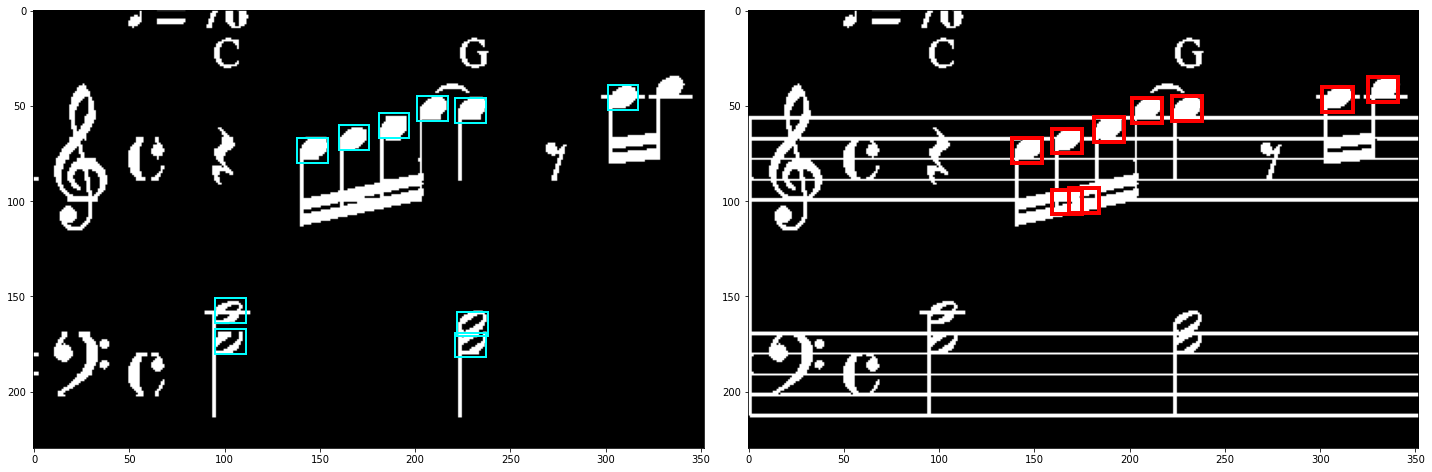

(11, 5) 0.47716733000495215
(9, 5) 0.016861128103401925


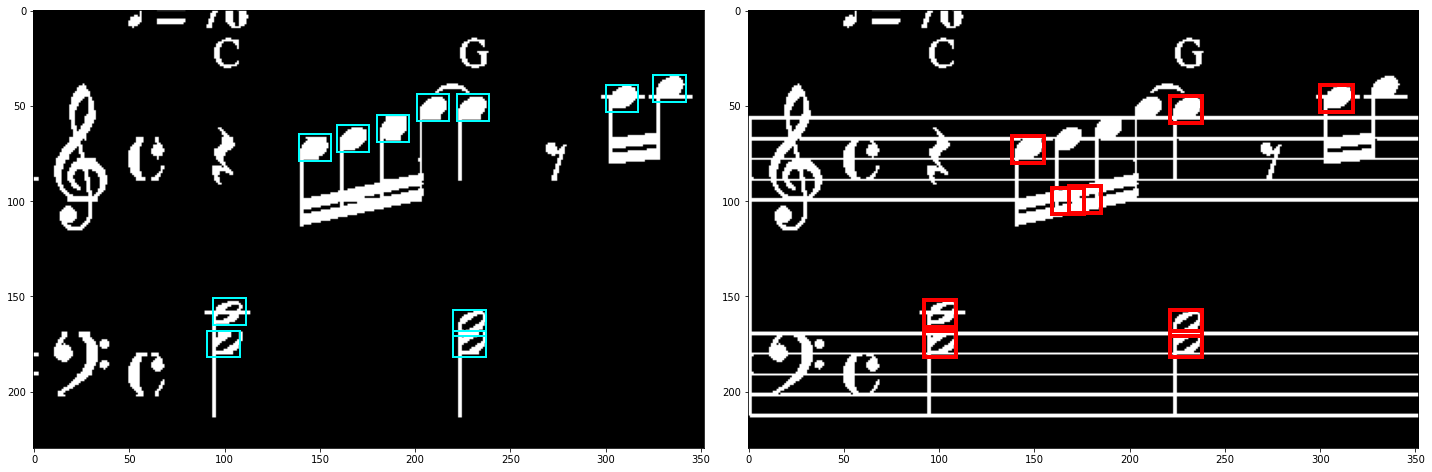

(9, 5) 0.46664636996057296
(3, 5) 0.015109324206908544


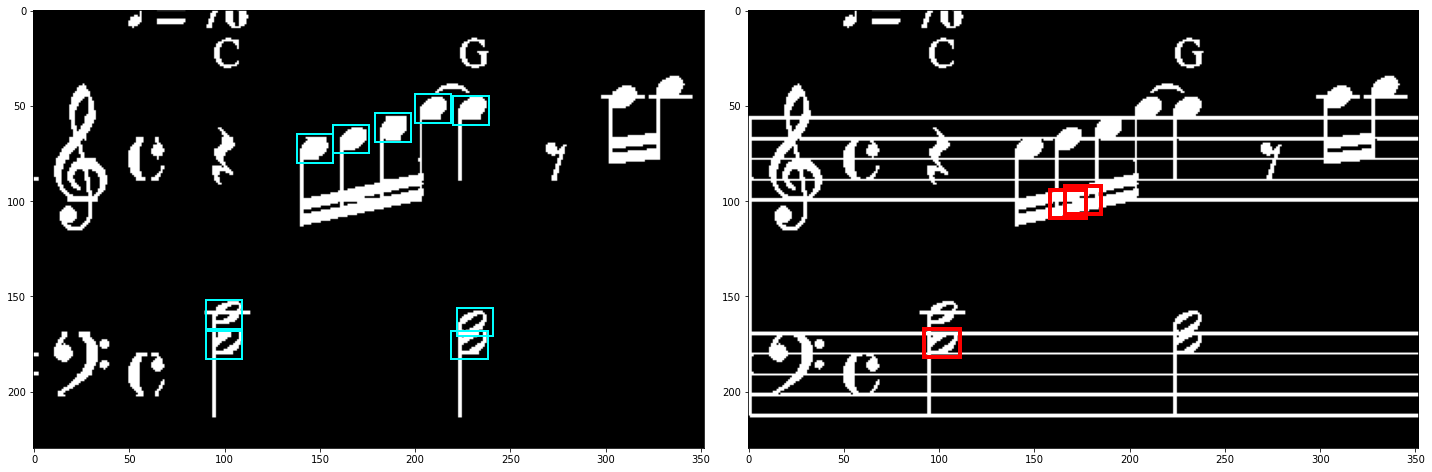

In [9]:
category_path = './data/symbols/Notes/Half'

template_path_list = fs.get_image_path(category_path)

measure_sample = 0

for template_path in template_path_list:
    print('-=-=-=-=-=-=-=-=-=-')
    t = OMR.Template(template_path)
    
    basis_scale = systems[system_sample].staves[0].interval/t.info['staff_interval']   
    print(basis_scale)
    
    for k in range(-1, 1+1):
        scale_factor = basis_scale+k*max(t.ssf)
        
        bboxes1_, res1 = t.find_high_matches(measures[measure_sample].image_line_removed, resize_factor=scale_factor, 
                                          threshold=0.45, method=cv2.TM_CCOEFF_NORMED)
        bboxes2_, res2 = t.find_high_matches(measures[measure_sample].image, resize_factor=scale_factor, 
                                          threshold=0.03, method=cv2.TM_SQDIFF_NORMED)
        h, w = t.resize_image['image'].shape
        
        bboxes1 = fs.non_maximum_suppression(bboxes1_, threshold=0.7, higher_best=False)
        bboxes2 = fs.non_maximum_suppression(bboxes2_, threshold=0.7, higher_best=False)
        print(bboxes1.shape, np.mean(bboxes1[:,0]))
        print(bboxes2.shape, np.mean(bboxes2[:,0]))
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(measures[measure_sample].image_line_removed, cmap='gray')
        ax[1].imshow(measures[measure_sample].image, cmap='gray')
        for xy in bboxes1[:,1:3]:
            ax[0].add_patch(patches.Rectangle(xy, w, h, fill=False, edgecolor='cyan', linewidth=2))
        for xy in bboxes2[:,1:3]:
            ax[1].add_patch(patches.Rectangle(xy, w, h, fill=False, edgecolor='red', linewidth=4))
        
        fig.tight_layout()
        plt.show()
    break

-=-=-=-=-=-=-=-=-=-
0.6875
(3, 5) 0.07701319704453151
(3, 5) 0.07701319704453151


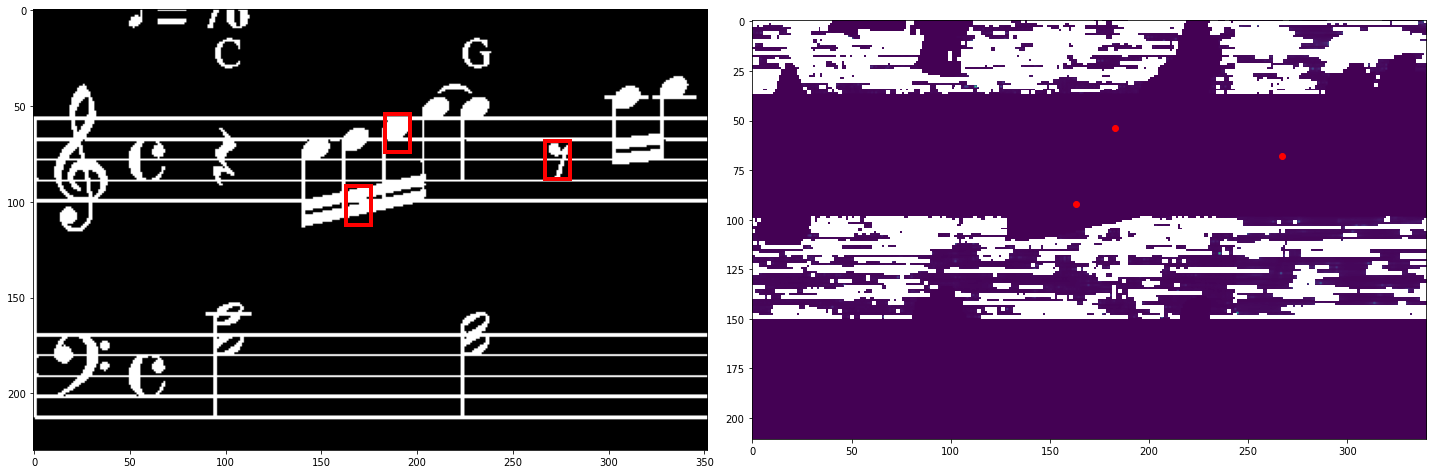

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0, 5) nan
(0, 5) nan


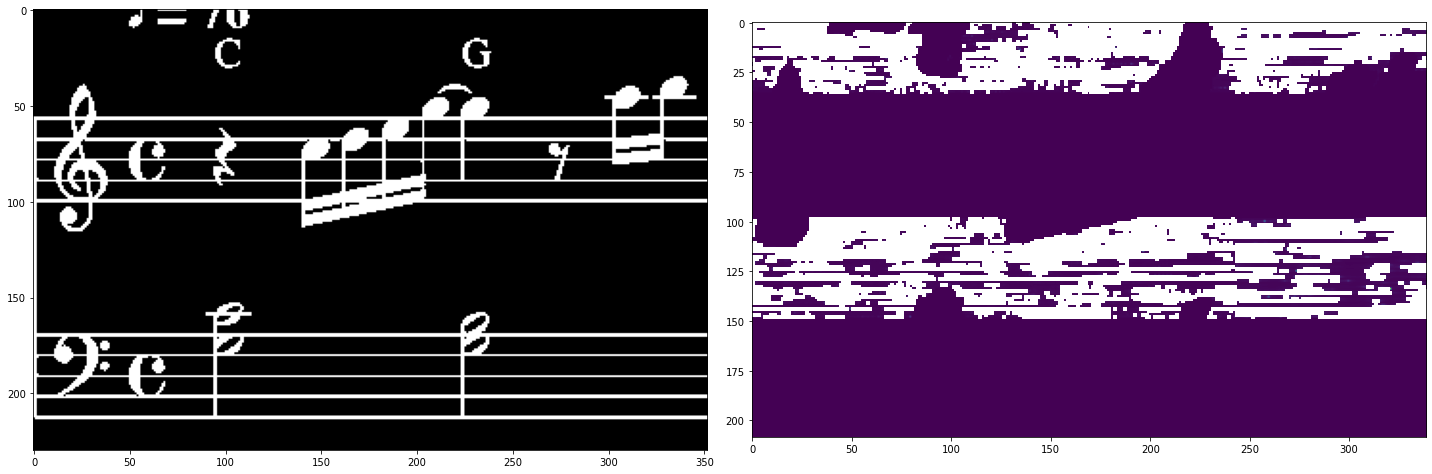

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0, 5) nan
(0, 5) nan


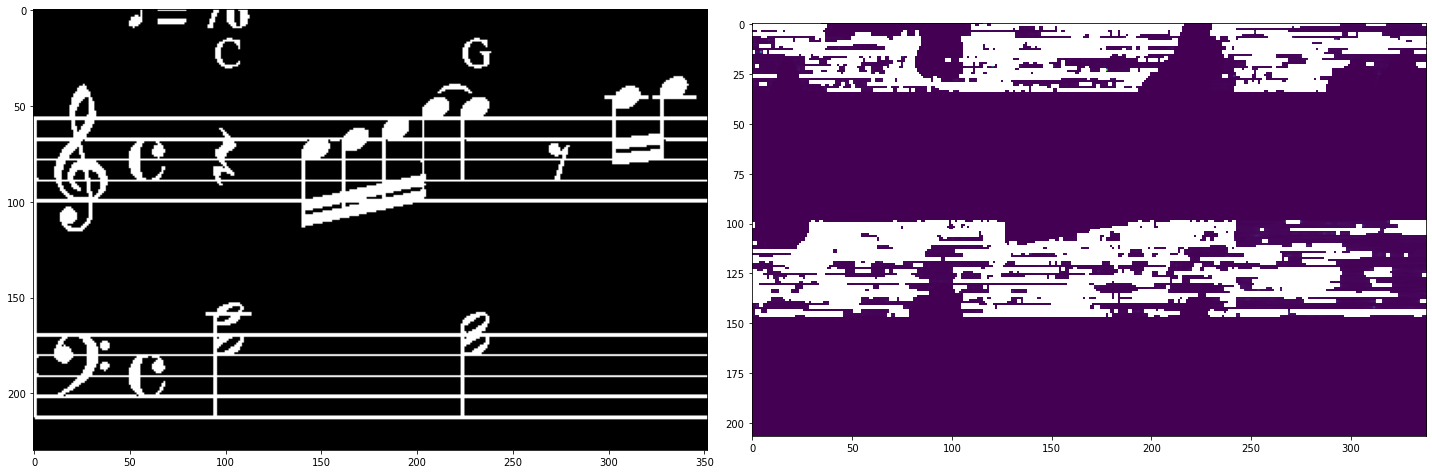

In [10]:
category_path = './data/symbols/Rests/Eighth'

template_path_list = fs.get_image_path(category_path)

measure_sample = 0

for template_path in template_path_list:
    print('-=-=-=-=-=-=-=-=-=-')
    t = OMR.Template(template_path)
    
    basis_scale = systems[system_sample].staves[0].interval/t.info['staff_interval']   
    print(basis_scale)
    
    for k in range(-1, 1+1):
        scale_factor = basis_scale+k*max(t.ssf)
        
        bboxes, res = t.find_high_matches(measures[measure_sample].image, resize_factor=scale_factor, threshold=0.1, method=cv2.TM_SQDIFF_NORMED)
        h, w = t.resize_image['image'].shape
        
        print(bboxes.shape, np.mean(bboxes[:,0]))
        bboxes2 = fs.non_maximum_suppression(bboxes, threshold=0.7, higher_best=False)
        print(bboxes2.shape, np.mean(bboxes2[:,0]))
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(measures[measure_sample].image, cmap='gray')
        for xy in bboxes[:,1:3]:
            ax[0].add_patch(patches.Rectangle(xy, w, h, fill=False, edgecolor='cyan', linewidth=2))
        for xy in bboxes2[:,1:3]:
            ax[0].add_patch(patches.Rectangle(xy, w, h, fill=False, edgecolor='red', linewidth=4))
        
        ax[1].imshow(res)
        ax[1].plot(*bboxes[:,1:3].T, 'or')
        fig.tight_layout()
        plt.show()
    scale_factor = basis_scale-max(t.ssf)

    bboxes, res = t.find_high_matches(measures[measure_sample].image, resize_factor=scale_factor, threshold=0.05, method=cv2.TM_SQDIFF_NORMED)
    h, w = t.resize_image['image'].shape
    break

-=-=-=-=-=-=-=-=-=-
0.6470588235294118
(3, 5) 0.09211378544569016
(2, 5) 0.09084504470229149
13649645000.0


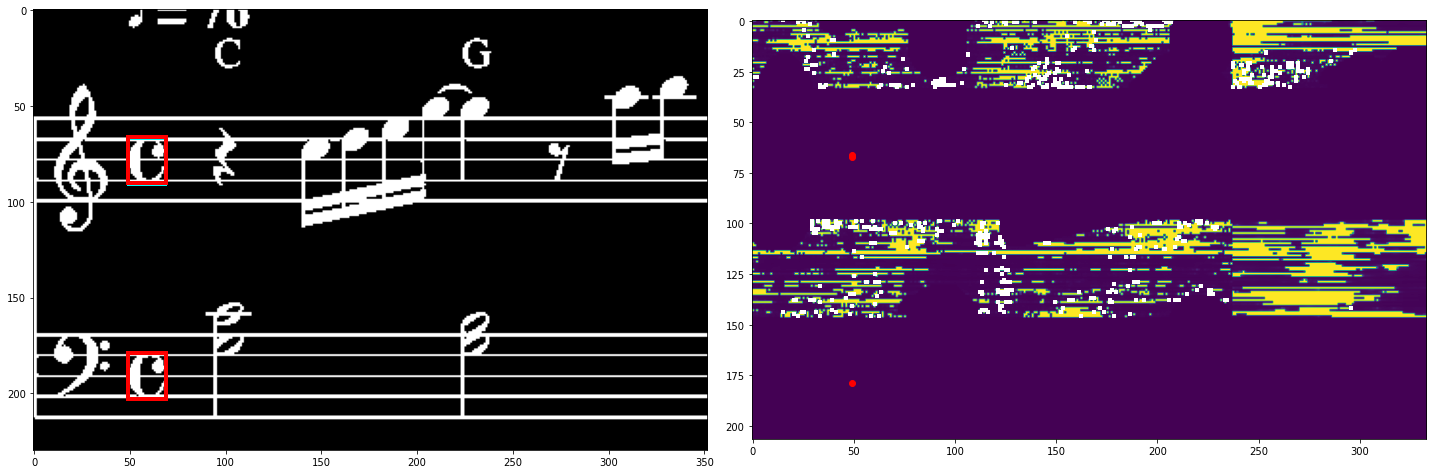

(3, 5) 0.07349581892291705
(2, 5) 0.06589638628065586
85426620000.0


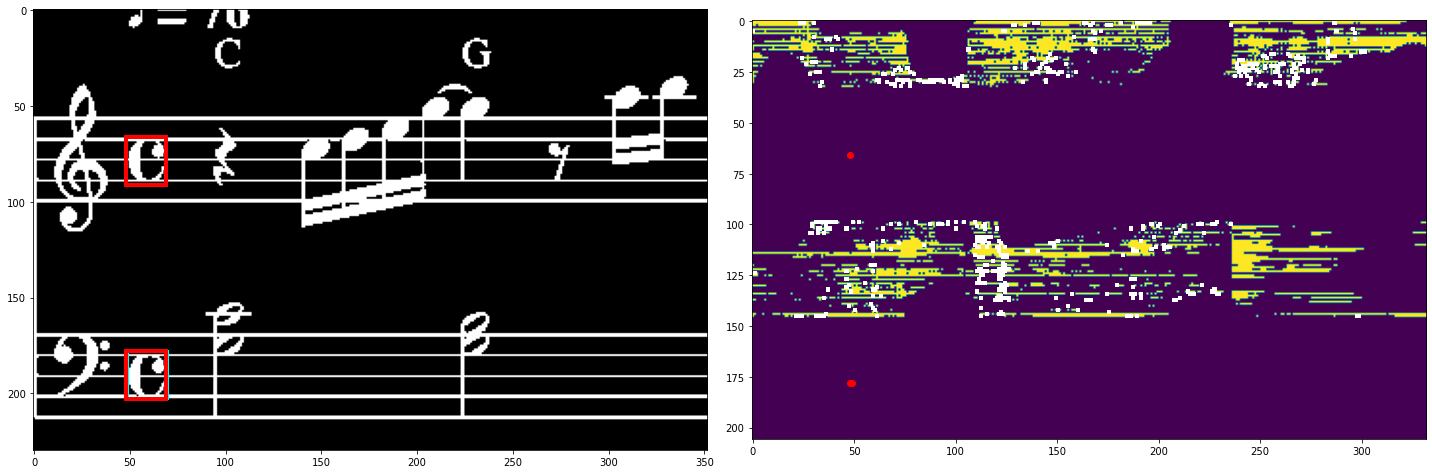

(3, 5) 0.05999684954682986
(2, 5) 0.053827064111828804
6624705000.0


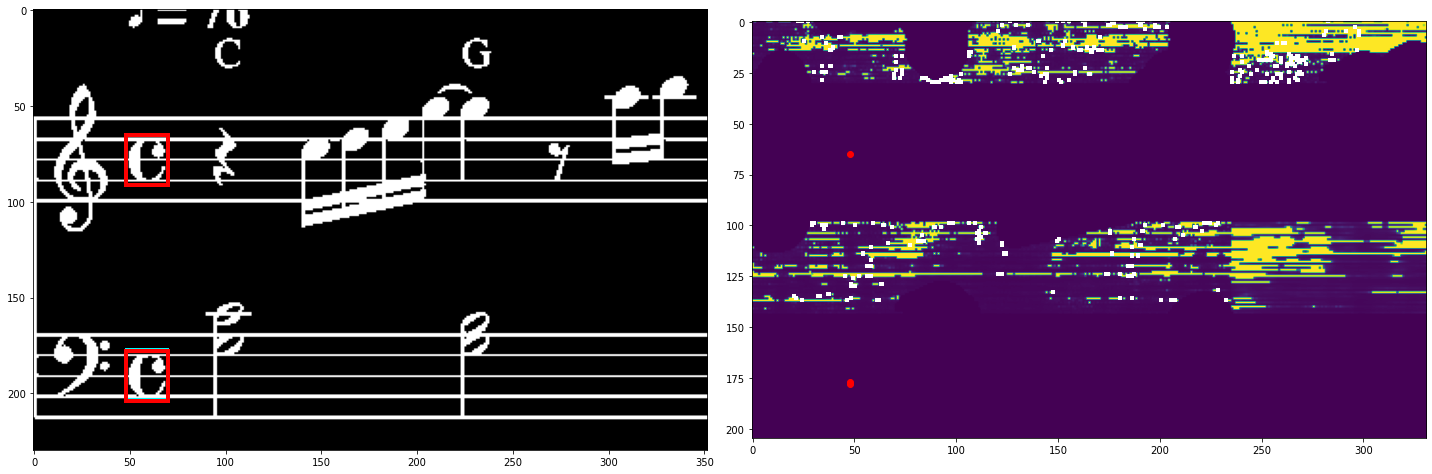

In [17]:
category_path = './data/symbols/Times/Time_4_4'

template_path_list = fs.get_image_path(category_path)

measure_sample = 0

for template_path in template_path_list:
    print('-=-=-=-=-=-=-=-=-=-')
    t = OMR.Template(template_path)
    
    basis_scale = systems[system_sample].staves[0].interval/t.info['staff_interval']   
    print(basis_scale)
    
    for k in range(-1, 1+1):
        scale_factor = basis_scale+k*max(t.ssf)
        
        bboxes, res = t.find_high_matches(measures[measure_sample].image, resize_factor=scale_factor, threshold=0.1, method=cv2.TM_SQDIFF_NORMED)
        h, w = t.resize_image['image'].shape
        
        print(bboxes.shape, np.mean(bboxes[:,0]))
        bboxes2 = fs.non_maximum_suppression(bboxes, threshold=0.7, higher_best=False)
        print(bboxes2.shape, np.mean(bboxes2[:,0]))
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(measures[measure_sample].image, cmap='gray')
        for xy in bboxes[:,1:3]:
            ax[0].add_patch(patches.Rectangle(xy, w, h, fill=False, edgecolor='cyan', linewidth=2))
        for xy in bboxes2[:,1:3]:
            ax[0].add_patch(patches.Rectangle(xy, w, h, fill=False, edgecolor='red', linewidth=4))
        
        max_val = np.max(res[~np.isnan(res)  & np.isfinite(res)])
        print(max_val)
        res[np.isnan(res) & ~np.isfinite(res)] = max_val
        
        ax[1].imshow(res)
        ax[1].plot(*bboxes[:,1:3].T, 'or')
        fig.tight_layout()
        plt.show()
    scale_factor = basis_scale-max(t.ssf)

    bboxes, res = t.find_high_matches(measures[measure_sample].image, resize_factor=scale_factor, threshold=0.05, method=cv2.TM_SQDIFF_NORMED)
    h, w = t.resize_image['image'].shape
    break